## 1、读取数据
采用决赛数据实验

In [4]:
import os
print(os.listdir("../input"))
import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

['dataID.png', 'phase2_ground_truth.hdf', 'phase2_train.csv', 'README.md']


In [5]:
def show_dataset_info(dataframe):
    """
    get a pandas dataframe as input and print the information.
    """
    # show basic info of the phase 2 training dataset
    print(dataframe.columns, '\n')
    print(dataframe.describe(), '\n')
    print(dataframe.head(), '\n')

In [6]:
# read datasets as pandas dataframes
phase2_train = pd.read_csv('../input/phase2_train.csv')
phase2_test = pd.read_hdf('../input/phase2_ground_truth.hdf')

In [5]:
show_dataset_info(phase2_train)

# 训练集有300多万样本，没有缺失值

Index(['timestamp', 'value', 'label', 'KPI ID'], dtype='object') 

          timestamp         value         label
count  3.004066e+06  3.004066e+06  3.004066e+06
mean   1.495420e+09  5.059672e+01  2.648211e-02
std    5.426934e+06  6.104686e+01  1.605641e-01
min    1.467302e+09 -3.011022e+00  0.000000e+00
25%    1.493983e+09  3.062500e+00  0.000000e+00
50%    1.496416e+09  3.192000e+01  0.000000e+00
75%    1.498642e+09  4.843000e+01  0.000000e+00
max    1.502343e+09  1.189250e+03  1.000000e+00 

    timestamp     value  label                                KPI ID
0  1476460800  0.012604      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
1  1476460860  0.017786      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
2  1476460920  0.012014      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
3  1476460980  0.017062      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
4  1476461040  0.023632      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd 



In [6]:
show_dataset_info(phase2_test)

# 测试集有291多万样本，没有缺失值

Index(['timestamp', 'value', 'label', 'KPI ID'], dtype='object') 

          timestamp         value         label
count  2.918847e+06  2.918847e+06  2.918847e+06
mean   1.503556e+09  4.948557e+01  1.869231e-02
std    6.042222e+06  5.331214e+01  1.354360e-01
min    1.471045e+09 -4.750345e+00  0.000000e+00
25%    1.502447e+09  3.800000e+00  0.000000e+00
50%    1.504542e+09  3.352000e+01  0.000000e+00
75%    1.506937e+09  6.253000e+01  0.000000e+00
max    1.509383e+09  1.865750e+03  1.000000e+00 

         timestamp     value  label                                KPI ID
107717  1482940800  0.048066      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
107718  1482940860  0.010651      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
107719  1482940920  0.014996      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
107720  1482940980  0.039722      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd
107721  1482941040  0.022452      0  da10a69f-d836-3baa-ad40-3e548ecf1fbd 



## 2、数据预处理

主要是将时间序列按照KPI ID划分，并进行规范化处理

In [7]:
np.unique(phase2_train['KPI ID'],return_index=True,return_counts=True)

(array(['05f10d3a-239c-3bef-9bdc-a2feeb0037aa',
        '0efb375b-b902-3661-ab23-9a0bb799f4e3',
        '1c6d7a26-1f1a-3321-bb4d-7a9d969ec8f0',
        '301c70d8-1630-35ac-8f96-bc1b6f4359ea',
        '42d6616d-c9c5-370a-a8ba-17ead74f3114',
        '43115f2a-baeb-3b01-96f7-4ea14188343c',
        '431a8542-c468-3988-a508-3afd06a218da',
        '4d2af31a-9916-3d9f-8a8e-8a268a48c095',
        '54350a12-7a9d-3ca8-b81f-f886b9d156fd',
        '55f8b8b8-b659-38df-b3df-e4a5a8a54bc9',
        '57051487-3a40-3828-9084-a12f7f23ee38',
        '6a757df4-95e5-3357-8406-165e2bd49360',
        '6d1114ae-be04-3c46-b5aa-be1a003a57cd',
        '6efa3a07-4544-34a0-b921-a155bd1a05e8',
        '7103fa0f-cac4-314f-addc-866190247439',
        '847e8ecc-f8d2-3a93-9107-f367a0aab37d',
        '8723f0fb-eaef-32e6-b372-6034c9c04b80',
        '9c639a46-34c8-39bc-aaf0-9144b37adfc8',
        'a07ac296-de40-3a7c-8df3-91f642cc14d0',
        'a8c06b47-cc41-3738-9110-12df0ee4c721',
        'ab216663-dcc2-3a24-b1ee-2c3e550

### 按照ID划分

In [7]:
"""
按照 KPI ID 进行划分。
将各个 ID 的所有value存入一个list
将各个 ID 的所有label存入一个list
"""
def get_time_series_from_dataframe(dataframe):
    """
    extract the time series set from given dataframe.
    """
    # training time series extraction
    ts_ids, ts_indexes, ts_point_counts = np.unique(dataframe['KPI ID'],
                                                    return_index=True,
                                                    return_counts=True)
    print('Extract are %d time series in the dataframe:' %(len(ts_ids)))

    # extract time series using ts_indexes
    ts_indexes.sort()
    ts_indexes = np.append(ts_indexes, len(dataframe))   # full ranges for extracting time series

    set_of_time_series = []
    set_of_time_series_label = []

    for i in np.arange(len(ts_indexes)-1):
        print('Extracting %d th time series with index %d and %d (exclusive)'
              %(i, ts_indexes[i], ts_indexes[i+1]))
        set_of_time_series.append(np.asarray(dataframe['value']
                                             [ts_indexes[i]:ts_indexes[i+1]]))
        set_of_time_series_label.append(np.asarray(dataframe['label']
                                                  [ts_indexes[i]:ts_indexes[i+1]]))
        
    return set_of_time_series, set_of_time_series_label

In [8]:
train_time_series_dataset, \
train_time_series_dataset_label = get_time_series_from_dataframe(phase2_train)
print()
test_time_series_dataset,\
test_time_series_dataset_label = get_time_series_from_dataframe(phase2_test)

Extract are 29 time series in the dataframe:
Extracting 0 th time series with index 0 and 107717 (exclusive)
Extracting 1 th time series with index 107717 and 116501 (exclusive)
Extracting 2 th time series with index 116501 and 127639 (exclusive)
Extracting 3 th time series with index 127639 and 136505 (exclusive)
Extracting 4 th time series with index 136505 and 145368 (exclusive)
Extracting 5 th time series with index 145368 and 154152 (exclusive)
Extracting 6 th time series with index 154152 and 162936 (exclusive)
Extracting 7 th time series with index 162936 and 171720 (exclusive)
Extracting 8 th time series with index 171720 and 300712 (exclusive)
Extracting 9 th time series with index 300712 and 429584 (exclusive)
Extracting 10 th time series with index 429584 and 558594 (exclusive)
Extracting 11 th time series with index 558594 and 687378 (exclusive)
Extracting 12 th time series with index 687378 and 816165 (exclusive)
Extracting 13 th time series with index 816165 and 944954 (e

![image](../input/dataID.png)

可以看到各个 ID 数据，最多十几万，少的8000

### 归一化-针对每个ID指标数据

In [9]:
def plot_time_series_info(set_of_time_series, set_of_time_series_scaled, set_of_time_series_label, index):
    """
    plot a time series from the given set of time series using the given index
    """
    assert(len(set_of_time_series) == len(set_of_time_series_scaled) == len(set_of_time_series_label))
    
    index_revised = index % len(set_of_time_series)
    ts = set_of_time_series[index_revised]
    ts_scaled = set_of_time_series_scaled[index_revised]
    ts_label = set_of_time_series_label[index_revised]
    
    plt.subplot(3,1,1)
    plt.plot(ts, 'r')
    plt.subplot(3,1,2)
    plt.plot(ts_scaled, 'b')
    plt.subplot(3,1,3)
    plt.plot(ts_label, 'k')
    plt.show()

Here is a training example of a time series after/before scaling/normalization/transforming:


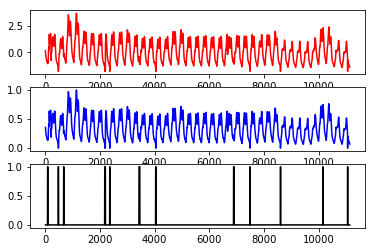

Here is a testing example of a time series after/before scaling/normalization/transforming:


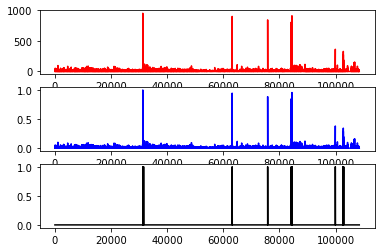

In [10]:
# import library to preprocess time series
# there is a big number of scalers, normalizers and transformers that could be of help
# pick one of them to maximize the anomaly detection performance in a specific application
from sklearn import preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import maxabs_scale

import random

# here we use the basic one (minmax_scale()) to get the baseline performance
train_time_series_dataset_size = len(train_time_series_dataset)
test_time_series_dataset_size = len(test_time_series_dataset)

train_time_series_dataset_scaled = []
test_time_series_dataset_scaled = []

for i in np.arange(train_time_series_dataset_size):
    train_time_series_dataset_scaled.append(minmax_scale(train_time_series_dataset[i]))
    
for i in np.arange(test_time_series_dataset_size):
    test_time_series_dataset_scaled.append(minmax_scale(test_time_series_dataset[i]))

# plot an example after scaling/normalization/transforming, random index
print('Here is a training example of a time series after/before scaling/normalization/transforming:')
plot_time_series_info(train_time_series_dataset, 
                      train_time_series_dataset_scaled,
                      train_time_series_dataset_label,
                      random.randint(0,train_time_series_dataset_size))

print('Here is a testing example of a time series after/before scaling/normalization/transforming:')
plot_time_series_info(test_time_series_dataset,
                      test_time_series_dataset_scaled, 
                      test_time_series_dataset_label,
                      random.randint(0,test_time_series_dataset_size))

## 3、特征工程

特征提取方案

- t时刻拟合值与实际值的对比特征
- t和t-1的对比特征
- 滑动窗口统计特征：均值、方差和分位数
- 滑动窗口 + 对比

特征集：多重窗口 * 统计特征 * 对比特征

### 特征提取具体方法：

For determining the abnormality of the data point in time step $T$, we are examining the following features:
* the 4 types of residuals (SARIMAX, SimpleExponentialSmoothing, SimpleExponentialSmoothing(add), Holt):
$$
f_{residual} = x_{T} - fittedvalue_{T}
$$
* the logarithm of the original time series:
$$
f_{log} = log(x_{T})
$$
* the difference of the original time series:
$$
f_{diff} = x_{T} - x_{T-1}
$$
* the percentage of the difference:
$$
f_{percent} = \frac{f_{diff}}{x_{T-1}}
$$
* the difference of difference
$$
f_{diff2} = f_{diff} - (x_{T-1} - x_{T-2})
$$
* the difference of current time series with accumulated mean
$$
f_{diff3} = x_{T} - accumulated_mean
$$

The following features are associated with different window sizes:
* the mean of the sliding window which is of size $W$:
$$
f_1 = mean([x_{T-W}, x_{T-W+1}, \cdots, x_T])
$$
* the variance of the sliding window which is of size $W$:
$$
f_2 = var([x_{T-W}, x_{T-W+1}, \cdots, x_T])
$$
* the difference between the means of time window to $T$ and $T-1$:
$$
f_3 = mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])
$$
* the percentage of the different between the means of time window to $T$ and $T-1$:
$$
f_4 = \frac{mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])}{mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}]}
$$
* the difference between the vars of time window to $T$ and $T-1$:
$$
f_5 = var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])
$$
* the percentage of the different between the vars of time window to $T$ and $T-1$:
$$
f_6 = \frac{var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])}{var([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}]}
$$
* the difference between the means of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_7 = mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])
$$
* the change ratio between the means of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_8 = \frac{mean([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}{mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}
$$
* the difference between the variances of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_9 = var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])
$$
* the change ratio between the variances of sliding windows from time step $T-W$ to $T$ and $T-2W$ to $T-W$:
$$
f_{10} = \frac{var([x_{T-W}, x_{T-W+1}, \cdots, x_T]) - var([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}{var([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])}
$$
* the difference between the current value and mean of the window from time step $T-W-1$ to $T-1$:
$$
f_{11} = x_{T} - mean([x_{T-W-1}, x_{T-W+1}, \cdots, x_{T-1}])
$$
* the difference between the current value and mean of the window from time step $T-2W$ to $T-W$:
$$
f_{12} = x_{T} - mean([x_{T-2W}, x_{T-W+1}, \cdots, x_{T-W}])
$$

所以，有至少 9 + 12 个特征。
对于设置不同n个窗口，可以得到12n+9特征


In [11]:
from statsmodels.tsa.api import SARIMAX, ExponentialSmoothing, SimpleExpSmoothing, Holt

In [12]:
def get_feature_logs(time_series):
    return np.log(time_series + 1e-2)

def get_feature_SARIMA_residuals(time_series):
    predict = SARIMAX(time_series,
                      trend='n').fit().get_prediction()
    return time_series - predict.predicted_mean

def get_feature_AddES_residuals(time_series):
    predict = ExponentialSmoothing(time_series, trend='add').fit(smoothing_level=1)
    return time_series - predict.fittedvalues

def get_feature_SimpleES_residuals(time_series):
    predict = SimpleExpSmoothing(time_series).fit(smoothing_level=1)
    return time_series - predict.fittedvalues

def get_feature_Holt_residuals(time_series):
    predict = Holt(time_series).fit(smoothing_level=1)
    return time_series - predict.fittedvalues

In [13]:
# 传入的是一个指标的时间序列，返回的是这个指标的针对每个时刻的特征数组组合而成的list
def get_features_and_labels_from_a_time_series(time_series, time_series_label, Windows, delay):
    """
    Input: time_series, time_series_label, Window, delay (for determining vital data)
    
    In a time series dataset, it maintains a list of values.
    We'll convert the list of values into a list of feature vectors,
    each feature vector corresponds to a time point in the time series.
    
    For example: a time series [1,2,3,4,5] --> a featured dataset [[1,2,3],[2,3,4],[3,4,5]] (use one window size 3)
    
    The labels for the feature vectors are remained and returned.
    
    time_series: a list of values, an array
    time_series_label: a list of labels, an array
    Windows: the window sizes for time series feature extraction, an array
    delay: the maximum delay for effectively detect an anomaly
    
    Output: features_for_the_timeseries (a list of arrays), 
            labels_for_the_timeseries (a list of arrays), 
            vital_labels_for_the_timeseries (a list of arrays)
    """    
    data = []
    data_label = []
    data_label_vital = []
    
    start_point = 2*max(Windows)
    start_accum = 0
    
    # features from tsa models
    time_series_SARIMA_residuals = get_feature_SARIMA_residuals(time_series)
    time_series_AddES_residuals = get_feature_AddES_residuals(time_series)
    time_series_SimpleES_residuals = get_feature_SimpleES_residuals(time_series)
    time_Series_Holt_residuals = get_feature_Holt_residuals(time_series)
    
    # features from tsa models for time series logarithm
    time_series_logs = get_feature_logs(time_series)
    
    # 针对每一个时刻，得到一系列特征（ 9 + 12 * n ）
    for i in np.arange(start_point, len(time_series)):        
        # the datum to put into the data pool
        datum = []
        datum_label = time_series_label[i]        
        
        # fill the datum with f01-f09
        diff_plain = time_series[i] - time_series[i-1]
        start_accum = start_accum + time_series[i]
        mean_accum = (start_accum)/(i-start_point+1)
        
        # f01-f04: residuals
        datum.append(time_series_SARIMA_residuals[i])
        datum.append(time_series_AddES_residuals[i])
        datum.append(time_series_SimpleES_residuals[i])
        datum.append(time_Series_Holt_residuals[i])
        # f05: logarithm
        datum.append(time_series_logs[i])
        
        # f06: diff
        datum.append(diff_plain)
        # f07: diff percentage
        datum.append(diff_plain/(time_series[i-1] + 1e-10))  # to avoid 0, plus 1e-10
        # f08: diff of diff - derivative
        datum.append(diff_plain - (time_series[i-1] - time_series[i-2]))
        # f09: diff of accumulated mean and current value
        datum.append(time_series[i] - mean_accum)

        # fill the datum with features related to windows
        # loop over different windows size to fill the datum
        for k in Windows:
            mean_w = np.mean(time_series[i-k:i+1])
            var_w = np.mean((np.asarray(time_series[i-k:i+1]) - mean_w)**2)
            #var_w = np.var(time_series[i-k:i+1])
            
            mean_w_and_1 = mean_w + (time_series[i-k-1]-time_series[i])/(k+1)
            var_w_and_1 = np.mean((np.asarray(time_series[i-k-1:i]) - mean_w_and_1)**2)
            #mean_w_and_1 = np.mean(time_series[i-k-1:i])
            #var_w_and_1 = np.var(time_series[i-k-1:i])
            
            mean_2w = np.mean(time_series[i-2*k:i-k+1])
            var_2w = np.mean((np.asarray(time_series[i-2*k:i-k+1]) - mean_2w)**2)
            #var_2w = np.var(time_series[i-2*k:i-k+1])
            
            # diff of sliding windows
            diff_mean_1 = mean_w - mean_w_and_1
            diff_var_1 = var_w - var_w_and_1
            
            # diff of jumping windows
            diff_mean_w = mean_w - mean_2w
            diff_var_w = var_w - var_2w
            
            # f1
            datum.append(mean_w)  # [0:2] is [0,1]
            # f2
            datum.append(var_w)
            # f3
            datum.append(diff_mean_1)
            # f4
            datum.append(diff_mean_1/(mean_w_and_1 + 1e-10))
            # f5
            datum.append(diff_var_1)
            # f6
            datum.append(diff_var_1/(var_w_and_1 + 1e-10))
            # f7
            datum.append(diff_mean_w)
            # f8
            datum.append(diff_mean_w/(mean_2w + 1e-10))
            # f9
            datum.append(diff_var_w)
            # f10
            datum.append(diff_var_w/(var_2w + 1e-10))
            
            # diff of sliding/jumping windows and current value
            # f11
            datum.append(time_series[i] - mean_w_and_1)
            # f12
            datum.append(time_series[i] - mean_2w)

        data.append(np.asarray(datum)) # 将此时刻产生的特征转换为 ndarray ，放入data列表中
        data_label.append(np.asarray(datum_label))

        # an important step is to identify the start anomalous points which are said to be critical
        # if the anomaly is detected within delay window of the occurence of the first anomaly
        if datum_label == 1 and sum(time_series_label[i-delay:i]) < delay:
            # 如果成立，说明是在时延内首次出现异常
            data_label_vital.append(np.asarray(1))
        else:
            data_label_vital.append(np.asarray(0))
            
    return data, data_label, data_label_vital

In [14]:
num_of_feature_with_value = 9
num_of_feature_with_window = 12

## 4、过采样

In [15]:
def get_expanded_featuers_and_labels(data_pool, data_pool_label, data_pool_label_vital, oversample=0):
    
    assert(len(data_pool) == len(data_pool_label) == len(data_pool_label_vital))

    if oversample == 0:
        return data_pool, data_pool_label
    
    data_pool_len = len(data_pool)
    
    # the data points and labels to be appended into the data/label pool
    data_pool_plus = []
    data_pool_plus_label = []
    for i in np.arange(data_pool_len):
        if data_pool_label[i] == 1: # anomalous point
            data_pool_plus.append(data_pool[i])
            data_pool_plus_label.append(data_pool_label[i])

    # the data points and labels to be appended into the data/label pool (critical ones)
    data_pool_vital = []
    data_pool_vital_label = []
    for i in np.arange(data_pool_len):
        if data_pool_label_vital[i] == 1: # vital anomalous point
            data_pool_vital.append(data_pool[i])
            data_pool_vital_label.append(data_pool_label_vital[i])

    # oversample abnormal data instances and vital abnormal data instances to balance the dataset
    data_pool_complete = data_pool + \
                         oversample * data_pool_plus + \
                         oversample * data_pool_vital
    # list可以直接 + 和 * ，相当于组合到一起
    # a = [[1,2,3],[5,6,7]]   b = [[11,22,33]]    c = a + 2* b  ====>  [[1, 2, 3], [5, 6, 7], [11, 22, 33], [11, 22, 33]]
    data_pool_complete_label = data_pool_label + \
                               oversample * data_pool_plus_label + \
                               oversample * data_pool_vital_label

    assert(len(data_pool_complete) == len(data_pool_complete_label))
    print('The augment size of the dataset: %d = %d + %d * %d + %d * %d' %(len(data_pool_complete),
                                                                           len(data_pool),
                                                                           oversample,
                                                                           len(data_pool_plus),
                                                                           oversample,
                                                                           len(data_pool_vital)))

    # data_pool_complete (X) and data_pool_complete_label (y) should be ready for training
    return data_pool_complete, data_pool_complete_label

## 5、生成样本集

### 训练集生成

In [16]:
# 1) feature engineering for training dataset
# specify the set of window sizes
# the maximum number is 125 means the start point to consider anomalies is 250, i.e., max(2W).
W = np.asarray([2, 5, 10, 25, 50, 100])
delay = 7

# training: data pool for labeled data points (presented by 6n+2 features)
train_data_pool = []
train_data_pool_label = []
train_data_pool_label_vital = []

# loop over all the time series
for i in np.arange(train_time_series_dataset_size):    
    # loop over all the data points in each time series
    data, \
    data_label, \
    data_label_vital = get_features_and_labels_from_a_time_series(train_time_series_dataset_scaled[i],
                                                                  train_time_series_dataset_label[i],
                                                                  W, delay)
    train_data_pool = train_data_pool + list(scale(np.asarray(data)))
    #train_data_pool = train_data_pool + list(minmax_scale(abs(np.asarray(data))))
    #train_data_pool = train_data_pool + list(maxabs_scale(np.asarray(data)))
    
    train_data_pool_label = train_data_pool_label + data_label
    train_data_pool_label_vital = train_data_pool_label_vital + data_label_vital
    
# 2) over sampling
# the methodology to achieve over sampling is to pick samples from train_data according to train_data_label
# data_pool + data_pool_plus + data_pool_vital, there are three datasets to be merged
# data_pool_label + data_pool_plus_label + data_pool_vital_label, there are three label datasets to be merged
train_data_pool_complete, \
train_data_pool_complete_label = get_expanded_featuers_and_labels(train_data_pool, 
                                                                  train_data_pool_label, 
                                                                  train_data_pool_label_vital,
                                                                  1)

# now oversampling is set to 1, use oversampling currenlty .
# default oversampling is set to 0, do not use oversampling .


C:\Users\10938\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\D(Program)\AI\Anaconda3-4.3.1\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\D(Program)\AI\Anaconda3-4.3.1\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
D:\D(Program)\AI\Anaconda3-4.3.1\lib\site-packages\sklearn\preprocessing\data.py:160: UserWarning: Numerical issues were encountered when centering t

The augment size of the dataset: 3083807 = 2998266 + 1 * 78963 + 1 * 6578


In [17]:
# 查看生成样本集的数据大小
import sys as sys

print(len(train_data_pool_complete)) # 3083807 个样本
print(len(train_data_pool_complete_label))
print()
print(sys.getsizeof(train_data_pool_complete)) # 占用内存 24 MB
print(type(train_data_pool_complete)) # <class 'list'>


3083807
3083807

24670520
<class 'list'>


In [18]:
# 将样本集转换格式 list ==> DataFrame
train_data_pool_df = pd.DataFrame(train_data_pool_complete)

In [20]:
train_data_pool_df.head(5) # 81 columns

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,-0.018788,0.073468,0.073468,0.073468,-1.145107,0.073468,-0.013250,0.009548,0.056581,-0.948387,...,-0.051566,-0.230354,-0.000636,-0.003924,-0.223233,-0.141639,-0.063276,-0.032383,-0.031694,-0.166324
1,-0.271323,-0.178255,-0.178255,-0.178255,-1.574228,-0.178255,-0.013252,-0.146349,0.022000,-0.954710,...,-0.221752,-0.981295,-0.003168,-0.004410,-0.223287,-0.142131,-0.063788,-0.032383,-0.171357,-0.236893
2,-0.008664,0.087477,0.087477,0.087477,-1.338475,0.087477,-0.013245,0.154495,0.056158,-0.957001,...,-0.070995,-0.323262,0.001632,-0.003484,-0.219050,-0.141822,-0.063717,-0.032383,-0.098656,-0.197864
3,0.138870,0.229519,0.229519,0.229519,-0.911476,0.229519,-0.013248,0.082582,0.123059,-0.938609,...,0.077939,0.348624,0.000694,-0.003668,-0.217817,-0.141508,-0.063663,-0.032383,0.083477,-0.104417
4,-0.067657,0.017137,0.017137,0.017137,-0.886366,0.017137,-0.013251,-0.123477,0.115086,-0.894323,...,-0.141127,-0.638072,-0.021254,-0.007887,-0.215472,-0.141558,-0.064059,-0.032384,0.095666,-0.094645


In [31]:
print(train_data_pool_df.shape) # (3083807, 81)
print(sys.getsizeof(train_data_pool_df)) # 近 2G
print(sys.getsizeof(train_data_pool_complete)) # 近 24MB

(3083807, 81)
1998307040
24670520


In [22]:
train_data_pool_df.to_csv('../output/train_data.csv', index=False)

In [26]:
train_data_pool_label_df = pd.DataFrame(train_data_pool_complete_label)
print(train_data_pool_label_df.shape) # (3083807, 1)
train_data_pool_label_df.to_csv('../output/train_data_label.csv', index=False)

(3083807, 1)


In [27]:
# 随机采样，存10万数据
# Extracting 0 th time series with index 0 and 107717 (exclusive)

train_data_part_df = train_data_pool_df.iloc[0:100000,:]
train_data_part_df.shape #(100000, 81)

(100000, 81)

In [28]:

train_data_part_label_df = train_data_pool_label_df.iloc[0:100000,:]
train_data_part_label_df.shape #(100000, 1)

(100000, 1)

In [29]:
train_data_part_df.to_csv('../output/train_data_part.csv', index=False) # 159MB
train_data_part_label_df.to_csv('../output/train_data_label_part.csv', index=False) #292KB
# 数据集 0样本：96881  1样本：6119

In [35]:
# 随机抽取20万样本
train_sample = train_data_pool_df
train_sample['label'] = train_data_pool_label_df[0]
print(train_sample.shape)

(3083807, 82)


In [36]:
# 抽样
train_sample = train_sample.sample(n=200000)
train_sample.to_csv('../output/train_sample_200000.csv', index=False)

In [ ]:
#### store the data_pool and data_pool_flag into csv file
train_data_pool_df = pd.DataFrame(train_data_pool_complete)
train_data_pool_df.to_csv('../output/train_data.csv', index=False)
train_data_pool_label_df = pd.DataFrame(train_data_pool_complete_label)
train_data_pool_label_df.to_csv('../output/train_data_label.csv', index=False)

"""
#### read training dataset as pandas dataframes
train_data_pool_df = pd.read_csv('train_data.csv')
train_data_pool = list(np.asarray(train_data_pool_df))
train_data_pool_label_df = pd.read_csv('train_data_label.csv')
train_data_pool_label = list(np.asarray(train_data_pool_label_df))
"""

### 测试集生成

因为数据集较大，暂时先不用了。  
算法实验暂时使用取样的 100000 个样本集

In [ ]:
# feature engineering for testing dataset, a list of sequences
test_data_pool = []

# loop over all the time series
for i in np.arange(test_time_series_dataset_size):        
    # loop over all the data points in each time series
    data, \
    data_label, \
    data_label_vital = get_features_and_labels_from_a_time_series(test_time_series_dataset_scaled[i],
                                                                  test_time_series_dataset_label[i],
                                                                  W, delay)
    
    test_data_pool = test_data_pool + [list(scale(np.asarray(data)))]
    #test_data_pool = test_data_pool + [list(minmax_scale(abs(np.asarray(data))))]
    #test_data_pool = test_data_pool + [list(maxabs_scale(np.asarray(data)))]    

# due to the use of sliding windows, there should has (example):
print('The length of a time series, e.g., %d, is %d longer than that of its feature vectors, e.g., %d.' 
      %(len(test_time_series_dataset_scaled[0]), 2*max(W), len(test_data_pool[0])))

In [ ]:
"""
#### store testing dataset into csv file
test_data_pool_df = pd.DataFrame(test_data_pool)
test_data_pool_df.to_csv('test_data.csv', index=False)

#### read testing dataset as pandas dataframes
test_data_pool_df = pd.read_csv('test_data.csv')
test_data_pool = list(np.asarray(train_data_pool_label_vital_df))
"""